**Table of contents**<a id='toc0_'></a>    
- [Visualizing dyad.](#toc1_)    
  - [SVD Decomposition](#toc1_1_)    
  - [Matrix approximation](#toc1_2_)    
  - [Image compression](#toc1_3_)    
    - [Approximation error](#toc1_3_1_)    
    - [Compression factor](#toc1_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

#  [&#8593;](#toc0_) <a id='toc1_'></a>Visualizing dyad.

Consider an image from skimage.data. For simplicity, say that $X \in \mathbb{R}^{m \times n}$ is the matrix representing
that image. You are asked to visualize the dyad of the SVD Decomposition of $X$ and the result of compressing
the image via SVD. In particular:

In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt

##  [&#8593;](#toc0_) <a id='toc1_1_'></a>SVD Decomposition

Load the image into memory and compute its SVD, remebering that given a matrix $A \in \mathbb{R}^{m \times n}$  it's always possible to decompose it in the following form:

$$ A = U \Sigma V^T $$

where:
- $U \in \mathbb{R}^{m×m}$ is an orthogonal matrix with columns $u_i$ called left-singular vectors.
- $V \in \mathbb{R}^{n×n}$ is an orthogonal matrix with columns $v_i$ called right-singular vectors.
- $\Sigma \in \mathbb{R}^{m×n}$ is a matrix with $\Sigma_{i,j} = 0$ for each $i \neq j$ and the singular values $\sigma_i, i = 1 \dots \min\{m, n\}$ on the diagonal 

U=(512, 512), s=(512,), VT=(512, 512), S=(512, 512)


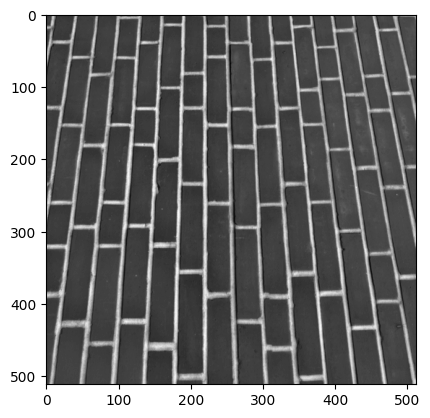

In [8]:
x = ski.data.brick()
m, n = x.shape

# Compute the SVD decomposition of x
U, s, VT = np.linalg.svd(x, full_matrices=True)
# s contains only the singular values
# Get the full S matrix
S = np.zeros((m, n))
S[:n, :n] = np.diag(s)
print(f'U={U.shape}, s={s.shape}, VT={VT.shape}, S={S.shape}')


plt.imshow(x, cmap='gray')
plt.show()

##  [&#8593;](#toc0_) <a id='toc1_2_'></a>Matrix approximation

Given a matrix $A \in \mathbb{R}^{m×n}$ and its SVD decomposition $A = U \Sigma V^T$ , we can construct a rank-1 matrix (*dyad*) $A_i \in \mathbb{R}^{m×n}$ as:

$$ A_i = u_i v_i^T $$

where $u_i \in \mathbb{R}^m$ is the $i$-th column of $U$ and $v_i \in \mathbb{R}^n$ is the $i$-th column of $V$.

Then, we can compose $A$ as a sum of *dyads*:

$$ A = \sum_{i=1}^{r} \sigma_i u_i {v_i}^T = \sum_{i=1}^{r} \sigma_i A_i$$

Visualize some of the *dyad* $\sigma_i u_i {v_i}^T$ of this decomposition. What do you notice?

**- The first *dyad* is the one with the most information, and with increasing $i$ the singular value $\sigma_i$ decrease and so the information decrease.**

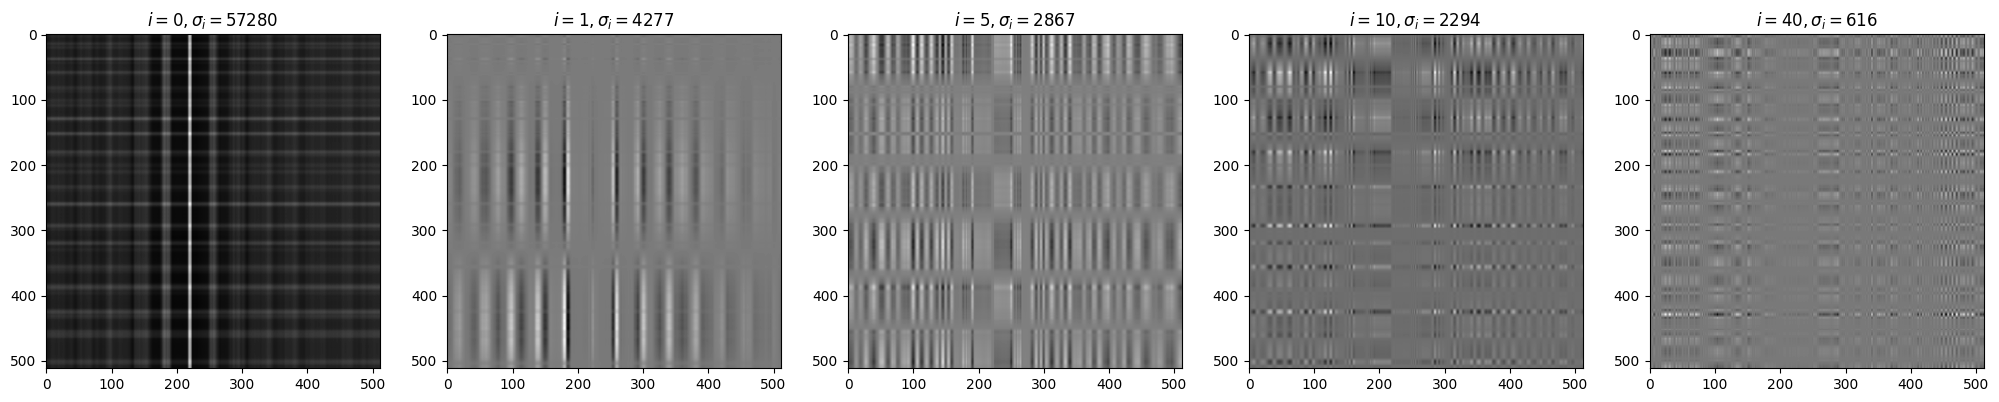

In [10]:
# We don't need x because we already calculated the SVD at the beginning
def i_rank(i):
    sigma = s[i]
    u = U[:,i:i+1]
    v = VT.T[:,i:i+1]
    return sigma * (u @ v.T)

# Plot some values
ii = [0,1,5,10,40]
plt.figure(figsize=(25,15))
for i in ii:
    res = i_rank(i)
    plt.subplot(1,len(ii),ii.index(i) + 1)
    plt.title(f"$i = {i}, \\sigma_i = {s[i]:.0f}$")
    plt.imshow(res, cmap='gray')

**Plot the singular values of $X$. Do you note something?**

**- The singular values with $i>100$ are almost $0$, meaning that the almost all the information is contained in the first $100$ singular values.**

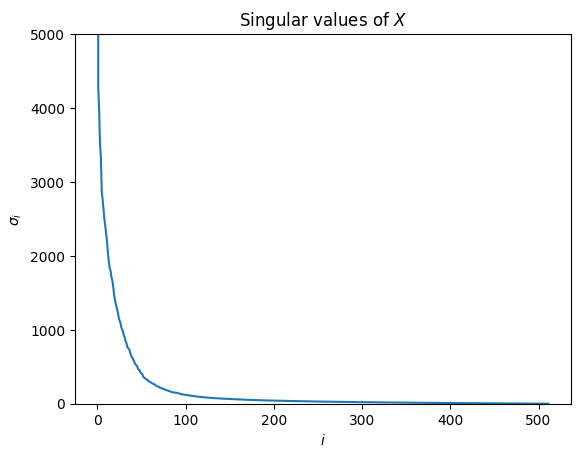

In [11]:
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.title('Singular values of $X$');
plt.ylim(top=5000)
plt.plot(s);

##  [&#8593;](#toc0_) <a id='toc1_3_'></a>Image compression

**Visualize the $k$-rank approximation of $X$ for different values of $k$. What do you observe?**
**- With increasing values of $k$ the image is more clear, and with $k = 50$ the image is almost identical to the original one. The main difference is observable in the noise present in the approximation because approximating the image we keep the most important tract of the image and we lost some details.**

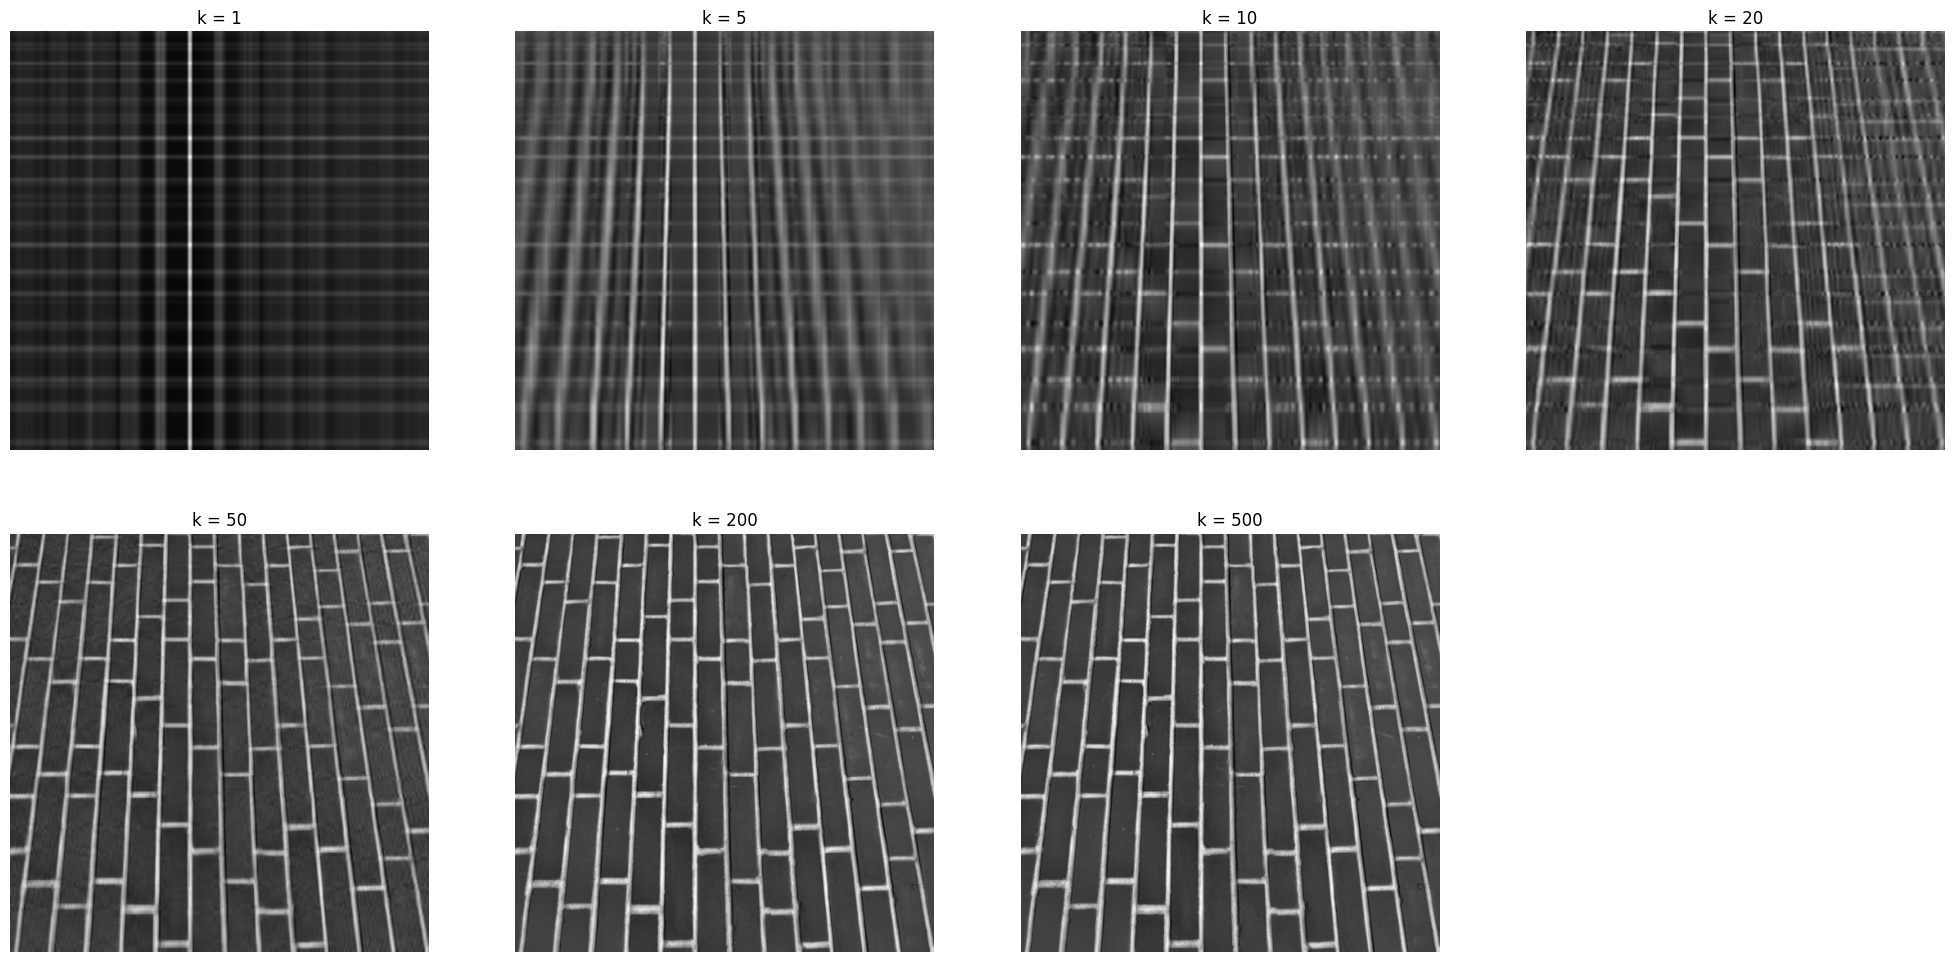

In [17]:
# My method
def k_rank(x,k):
    res = np.zeros(x.shape)
    for i in range(k):
        res += i_rank(i)
    return res

# Prof method
def k_rank_prof(k):
    return U[:, :k] @ S[:k, :k] @ VT[:k, :]

# Visualization
kk = [1,5,10,20,50,200,500]
plt.figure(figsize=(25,25))
for k in kk:
    res = k_rank(x,k)

    plt.subplot(4,4,kk.index(k) + 1)
    plt.title(f"k = {k}")
    plt.imshow(res, cmap='gray')
    plt.axis('off')

###  [&#8593;](#toc0_) <a id='toc1_3_1_'></a>Approximation error

Compute and plot the approximation error $||X − X_k||_2$ for increasing values of $k$, where $X_k$ is the
$k$-rank approximation of $k$.

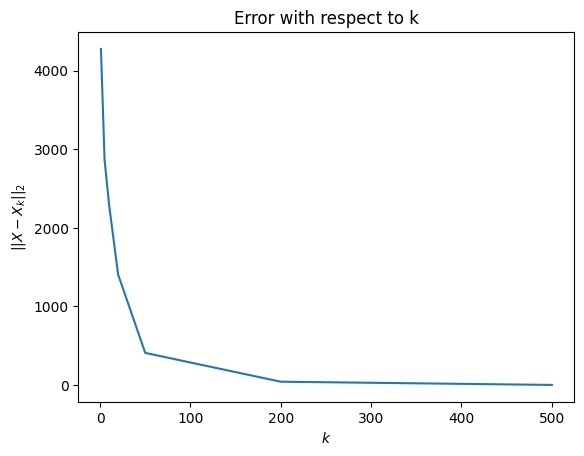

In [19]:
errors = []
for k in kk:
    k_rank_approx = k_rank(x,k)
    errors.append(np.linalg.norm(x-k_rank_approx,2))
plt.title("Error with respect to k")
plt.xlabel('$k$')
plt.ylabel('$||X - X_k||_2$')
plt.plot(kk,errors)
plt.show()

###  [&#8593;](#toc0_) <a id='toc1_3_2_'></a>Compression factor
Plot the compression factor $c_k = 1 - \frac{k(m+n+1)}{mn}$ for increasing $k$. If $c_k < 0$ it means that the $k$-rank approximation is using more space than the original matrix, so the compression is not only useless, but also counterproductive.

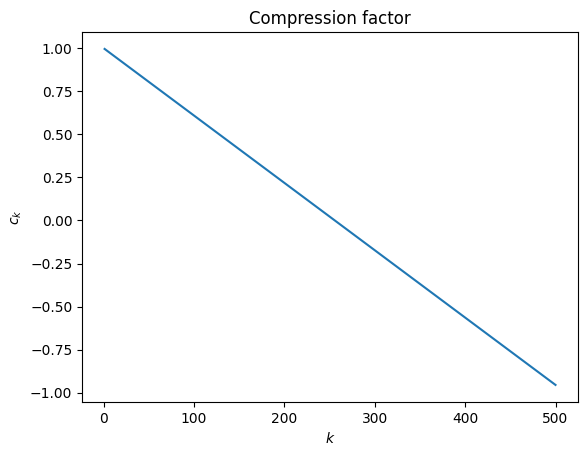

In [23]:
c_k = []
for k in kk:
    c_k.append(1 - k*(m+n+1)/(m*n))

plt.title('Compression factor')
plt.xlabel('$k$')
plt.ylabel('$c_k$')
plt.plot(kk,c_k);

What is the approximation error when the compressed image requires the same amount of informations of those of the uncompressed image (i.e. $c_k = 0$)?

$$ k = \frac{mn}{(m + n +1)} $$

this is derived from:

$$ A = \sum_{i=1}^{r} \sigma_i u_i {v_i}^T $$

knowing that $u_i$ is a scalar, $u_i$ is a $m$-dimensional vector and $v_i$ is a $n$ dimensional vector.

In [24]:
k = int(m*n / (m + n + 1))
print(f'With k={k} the compression factor is equal to 0, so the amount of information of the compressed image is the same as the original one')

With k=255 the compression factor is equal to 0, so the amount of information of the compressed image is the same as the original one


What do you observe if you plot the approximation error  $||X − X_k||_2$ compared with the plot of $\sigma_k$, for increasing values of $k$?

**As we can see from the plot below, they are approximately equals. This can be derived from:**

$$   \|X − X_k\|_2  = \|  \sum_{i=1}^{r}\sigma_i X_i - \sum_{j=1}^{k} \sigma_j X_j  \|_2 = \| \sum_{i=k+1}^{r} \sigma_i X_i \|_2 = \max(\sigma_i) = \sigma_{k+1}$$

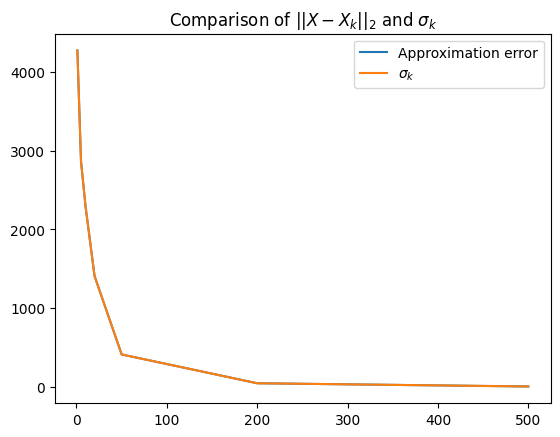

In [27]:
plt.plot(kk, errors, label = 'Approximation error')
plt.plot(kk, s[kk], label = '$\\sigma_k$')
plt.title('Comparison of $||X - X_k||_2$ and $\\sigma_k$')
plt.legend(loc="upper right")
plt.show()